In [296]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Рассмотрим тренировочную выборку, полученную в результате сбора данных с auto.ru:

In [297]:
train = pd.read_csv("raw_data.csv")

In [298]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18417 entries, 0 to 18416
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   body_type             18417 non-null  object 
 1   brand                 18417 non-null  object 
 2   color                 18417 non-null  object 
 3   fuel_type             18417 non-null  object 
 4   model_date_begin      18417 non-null  int64  
 5   model_date_end        18417 non-null  int64  
 6   name                  18417 non-null  object 
 7   model_name            18417 non-null  object 
 8   number_of_doors       18417 non-null  int64  
 9   production_date       18417 non-null  int64  
 10  vehicle_transmission  18417 non-null  object 
 11  engine_displacement   18417 non-null  int64  
 12  engine_power          18417 non-null  int64  
 13  mileage               18417 non-null  int64  
 14  complectation         18417 non-null  object 
 15  gear_type          

Видим, что тренировочный датасет содержит **18417** записей, и **22** признака. Для более детального анализа данных используем функции: 

Чтобы производить унификацию тренировочной и тестовой выборки, загрузим тестовый датасет:

In [299]:
test = pd.read_csv("test.csv")

In [300]:
def categorical_info(column_name, train, rotate=90, x_shift_mult=0, percentage=True):
    """Рисует распределение категориальных признаков и отображает их процентное содержание"""

    ax = sns.countplot(x=column_name,
                       data=train,
                       order=train[column_name].value_counts().index, orient="h")
    if percentage:
        total = len(train[column_name])
        for p in ax.patches:
            percentage = '{:.1f}%'.format(100 * p.get_height()/total)
            x = p.get_x() + x_shift_mult*p.get_width()
            y = p.get_y() + p.get_height()+8
            ax.annotate(percentage, (x, y))
    plt.xticks(rotation=rotate)


def numeric_info(train, bins=10):
    """Печатает описательные статистики числового признака, а также рисует его распределение"""

    print(train.describe()[["min", "max", "25%", "50%", "75%", "std"]])
    sns.distplot(train, bins=bins)


def get_differences(obj1, obj2):
    """Выводит на печать отличия в признаках выборок, возвращает индексы отличных элементов"""

    dif12 = list(set(list(obj1.value_counts().index)) -
                 set(list(obj2.value_counts().index)))
    print("================================")
    print("Train - Test differences:\n")
    print(obj1.value_counts()[dif12]) if len(
        dif12) != 0 else print("No differences")
    dif21 = list(set(list(obj2.value_counts().index)) -
                 set(list(obj1.value_counts().index)))
    print("================================")
    print("Test - Train differences:\n")
    print(obj2.value_counts()[dif21]) if len(
        dif21) != 0 else print("No differences")
    return dif12, dif21


def delete_differences(data, column_name, dif):
    """Удаляет найденные отличия из выборок"""
    # функция применялась при первой попытке приводить тренировочные данные под тестовые,
    # то есть удалять те записи из тренировочной выборки, значения признаков которых
    # отсутствуют в тестовой выборке. Проведённые эксперименты показали, что лучше их оставить
    before = data.shape[0]
    print(f"Число записей до удаления: {before}")
    data = data[~data[column_name].isin(dif[0])].reset_index(drop=True)
    after = data.shape[0]
    print(f"Число записей после удаления: {after}")
    print(f"Удалено {before-after} записей со значениями {dif[0]}")
    return data

##  body_type  (тип кузова)

Приведем все названия в train к нижнему регистру:

In [301]:
train.body_type = train.body_type.map(lambda x: x.lower())

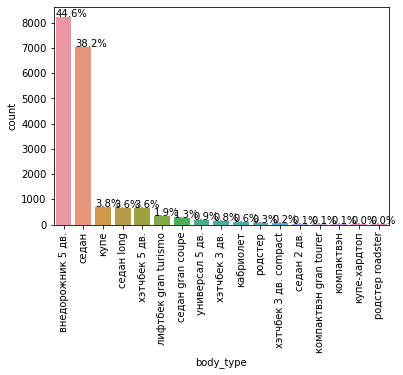

In [302]:
categorical_info("body_type", train, rotate=90)

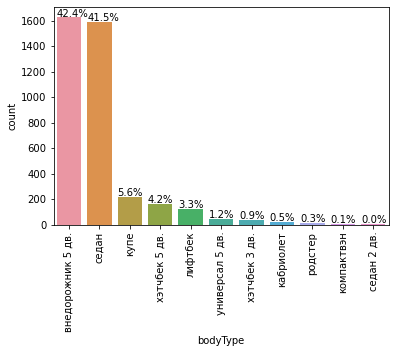

In [303]:
categorical_info("bodyType", test, rotate=90)

Посмотрим на отличия датасетов. Видим, что в train есть типы кузовов, отличающиеся по названию от тех, что есть в test. По сути, это все те же кузова, но с дополнительными названиями типа gran tourer. Избавимся от дополнительных названий, оставив основные. 

In [304]:
difs = get_differences(train.body_type, test.bodyType)

Train - Test differences:

купе-хардтоп                6
седан long                669
компактвэн gran tourer     17
лифтбек gran turismo      344
хэтчбек 3 дв. compact      43
родстер roadster            4
седан gran coupe          242
Name: body_type, dtype: int64
Test - Train differences:

лифтбек    125
Name: bodyType, dtype: int64


In [305]:
add_names = {"компактвэн gran tourer": "компактвэн",
             "лифтбек gran turismo": "лифтбек",
             "родстер roadster": "родстер",
             "хэтчбек 3 дв. compact": "хэтчбек 3 дв.",
             "седан gran coupe": "седан",
             "седан long": "седан",
             "купе-хардтоп": "купе"}

train.body_type.replace(add_names, inplace=True)

Сделаем замену названий на англоязычные аналоги:

In [306]:
body_dict = {'внедорожник 5 дв.': 'SUV',
             'седан': 'sedan',
             'купе': 'coupe',
             'хэтчбек 5 дв.': 'hatchback5',
             'лифтбек': 'liftback',
             'универсал 5 дв.': 'station_wagon',
             'хэтчбек 3 дв.': 'hatchback3',
             'кабриолет': 'cabriolet',
             'родстер': 'roadster',
             'компактвэн': 'compactvan',
             'седан 2 дв.': 'sedan2'
             }
train.body_type = train.body_type.map(body_dict)
test.bodyType = test.bodyType.map(body_dict)

Унифицируем название признака и проверим тип:

In [307]:
test.rename(columns={"bodyType": "body_type"}, inplace=True)

In [308]:
train.body_type.dtype == test.body_type.dtype

True

Посмотрим на распределения признака в обеих выборках после всех преобразований:

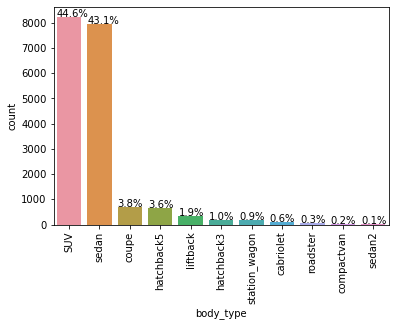

In [309]:
categorical_info("body_type", train, rotate=90)

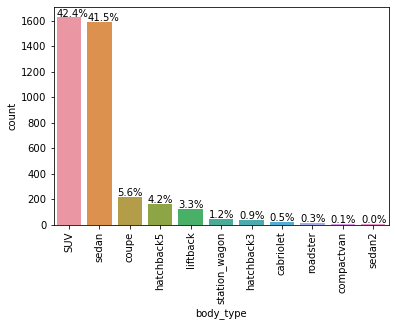

In [310]:
categorical_info("body_type", test, rotate=90)

## brand (марка автомобиля)

Убедимся, что данные, полученные с сайта, соответствуют марке BMW:

In [311]:
if len(train.brand.unique()) == 1:
    print(
        f'Датасет полностью представлен автомобилями марки {train.brand.unique()[0]}')

Датасет полностью представлен автомобилями марки BMW


## color (цвет автомобиля)

Преобразуем цвета тренировочного датасета из шестнадцатиричного формата в слова (русскоязычные):

In [312]:
color_dict = {'FAFBFB': 'белый',
              'CACECB': 'серебристый',
              '0000CC': 'синий',
              '97948F': 'серый',
              '040001': 'чёрный',
              'EE1D19': 'красный',
              '200204': 'коричневый',
              '007F00': 'зелёный',
              'C49648': 'бежевый',
              '4A2197': 'фиолетовый',
              'FF8649': 'оранжевый',
              '22A0F8': 'голубой',
              'FFC0CB': 'розовый',
              '660099': 'пурпурный',
              'DEA522': 'золотистый',
              'FFD600': 'жёлтый'
              }
train.color = train.color.map(color_dict)

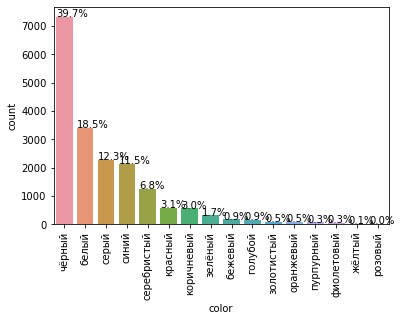

In [313]:
categorical_info("color", train, rotate=90)

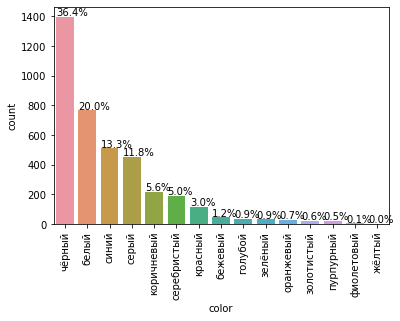

In [314]:
categorical_info("color", test, rotate=90)

Посмотрим на отличия в цветовой гамме:

In [315]:
difs = get_differences(train.color, test.color)

Train - Test differences:

розовый    2
Name: color, dtype: int64
Test - Train differences:

No differences


Видим, что в тренировочном датасете есть два автомобиля розового цвета. Этого цвета нет в тестовом наборе данных. В остальном набор цветов в выборках одинаков. 

Сделаем замену названий цветов на англоязычные аналоги:

In [316]:
color_dict = {'белый': 'white',
              'серебристый': 'silver',
              'синий': 'dark_blue',
              'серый': 'grey',
              'чёрный': 'black',
              'красный': 'red',
              'коричневый': 'brown',
              'зелёный': 'green',
              'бежевый': 'biege',
              'фиолетовый': 'violet',
              'оранжевый': 'orange',
              'голубой': 'blue',
              'пурпурный': 'purple',
              'золотистый': 'golden',
              'жёлтый': 'yellow'
              }
test.color = test.color.map(color_dict)

In [317]:
color_dict["розовый"] = "pink"
train.color = train.color.map(color_dict)

Посмотрим на распределения признака в обеих выборках после всех преобразований:

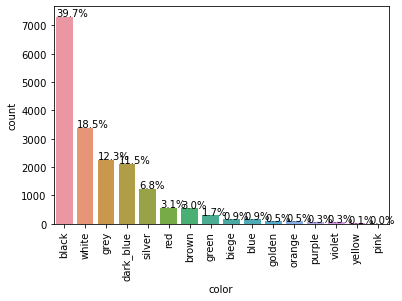

In [318]:
categorical_info("color", train, rotate=90)

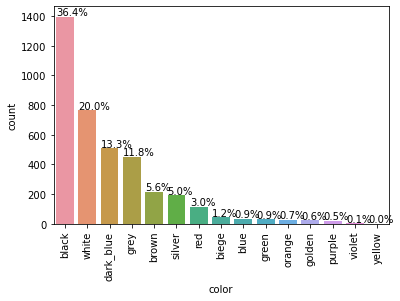

In [319]:
categorical_info("color", test, rotate=90)

In [320]:
train.color.dtype == test.color.dtype

True

## fuelType (тип двигателя)

Переименуем названия типов двигателей и посмотрим на распределение признака в датасетах:

In [321]:
fuel_dict = {'GASOLINE': "бензин",
             'DIESEL': "дизель",
             'HYBRID': "гибрид",
             'ELECTRO': "электро"
             }
train.fuel_type = train.fuel_type.map(fuel_dict)

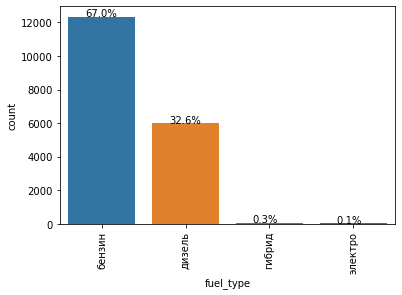

In [322]:
categorical_info("fuel_type", train, rotate=90, x_shift_mult=1/4)

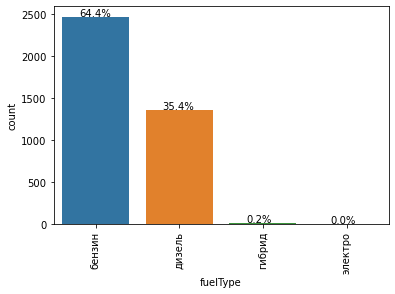

In [323]:
categorical_info("fuelType", test, rotate=90, x_shift_mult=1/4)

Видим, что распределения признака в обеих выборках очень похожи. Сделаем унификацию названия признака, а также заменим названия на англоязычные:

In [324]:
test.rename(columns={"fuelType": "fuel_type"}, inplace=True)

In [325]:
fuel_dict = {"бензин": "petrol",
             "дизель": "diesel",
             "гибрид": "hybrid",
             "электро": "electro"
             }

train.fuel_type = train.fuel_type.map(fuel_dict)
test.fuel_type = test.fuel_type.map(fuel_dict)

Посмотрим на распределения признака в обеих выборках после всех преобразований:

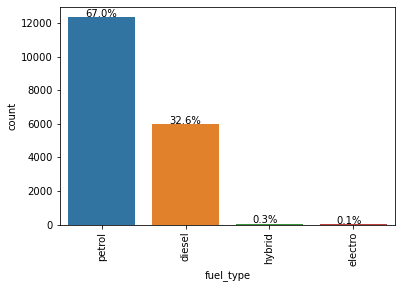

In [326]:
categorical_info("fuel_type", train, rotate=90, x_shift_mult=1/4)

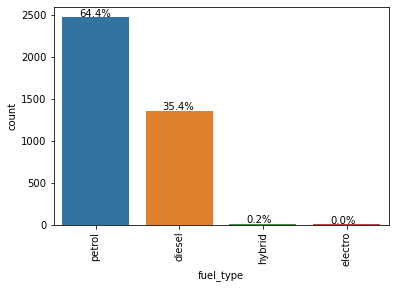

In [327]:
categorical_info("fuel_type", test, rotate=90, x_shift_mult=1/4)

In [328]:
train.fuel_type.dtype == test.fuel_type.dtype

True

## model_date_begin (год начала выпуска модели)

Переведём год для test из float64 в int32 (совет от автора baseline)

In [329]:
test.modelDate = test.modelDate.astype("int32")
train.model_date_begin = train.model_date_begin.astype("int32")

min    1972.00000
max    2020.00000
25%    2005.00000
50%    2009.00000
75%    2014.00000
std       7.75705
Name: model_date_begin, dtype: float64


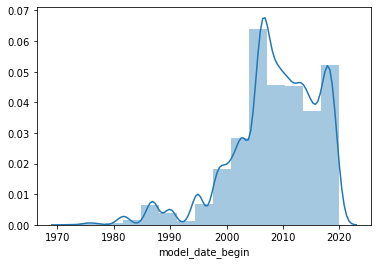

In [330]:
numeric_info(train.model_date_begin, bins=15)

min    1975.000000
max    2019.000000
25%    2007.000000
50%    2011.000000
75%    2014.000000
std       5.451623
Name: modelDate, dtype: float64


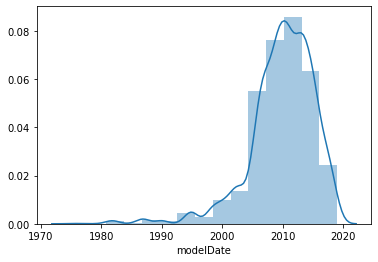

In [331]:
numeric_info(test.modelDate, bins=15)

Из визуального анализа распределений следует, что они во многом схожи, но в тренировочных данных слишком много новых авто 2020 года. Посмотрим на отличия:

In [332]:
difs = get_differences(train.model_date_begin, test.modelDate)

Train - Test differences:

1988      3
1989      6
2020    147
1992      2
1997      2
1972      3
1976     10
Name: model_date_begin, dtype: int64
Test - Train differences:

No differences


Действительно, в тренировочных данных присутствуют 147 автомобилей, производство которых началось в 2020 году. Остальные отличия несущественны, так как попадают во временной диапазон начала выпуска автомобилей для тестового набора, за исключением, может быть, трех автомобилей 1972 года. 

In [333]:
test.rename(columns={"modelDate": "model_date_begin"}, inplace=True)

Немного изменим зачение признака, оставив при этом его название, а именно: найдем количество лет, которое прошло с момента запуска модели в производство

In [334]:
train.model_date_begin = 2020 - train.model_date_begin
test.model_date_begin = 2020 - test.model_date_begin

Посмотрим на распределения признака в обеих выборках после всех преобразований:

min     0.00000
max    48.00000
25%     6.00000
50%    11.00000
75%    15.00000
std     7.75705
Name: model_date_begin, dtype: float64


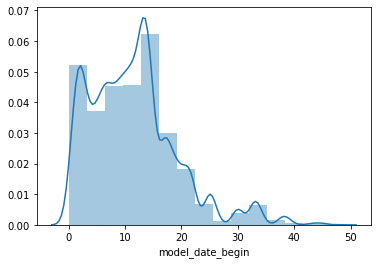

In [335]:
numeric_info(train.model_date_begin, bins=15)

min     1.000000
max    45.000000
25%     6.000000
50%     9.000000
75%    13.000000
std     5.451623
Name: model_date_begin, dtype: float64


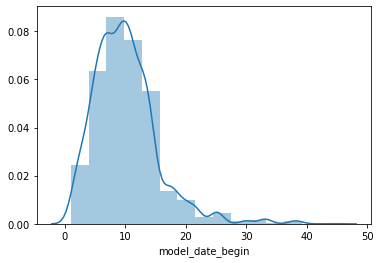

In [336]:
numeric_info(test.model_date_begin, bins=15)

In [337]:
train.model_date_begin.dtype == test.model_date_begin.dtype

True

## model_date_end (год завершения выпуска модели)

min    1976.00000
max    2020.00000
25%    2010.00000
50%    2013.00000
75%    2019.00000
std       6.69527
Name: model_date_end, dtype: float64


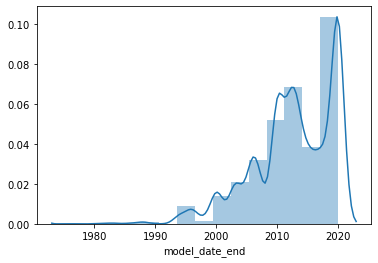

In [338]:
numeric_info(train.model_date_end, bins=15)

К сожалению, оказалось, что такой характеристики нет в тестовом датасете. 

## name (основные характеристики автомобиля)

Посмотрим на отличия в признаке. Видим, что в тренировочной выборке есть 278 конфигураций авто, которых нет в тестовой. И наоборот, в тестовой тоже есть автомобили, которых нет в тренировочной.

In [339]:
difs = get_differences(train.name, test.name)

Train - Test differences:

730i 3.0 MT (218 л.с.)     6
318i 1.9 AT (140 л.с.)     3
840i 4.0 AT (286 л.с.)     2
3.0 AT (231 л.с.)          1
2.0d AT (190 л.с.) 4WD     2
                          ..
528Li 2.0 AT (245 л.с.)    1
550i 4.8 MT (367 л.с.)     1
316i 1.6 MT (122 л.с.)     1
735Li 3.6 AT (272 л.с.)    5
135i 3.0 AMT (306 л.с.)    1
Name: name, Length: 278, dtype: int64
Test - Train differences:

528i 3.0 AT (258 л.с.) 4WD                 1
420i 2.0 AT (184 л.с.)                     9
CS 3.0 AMT (460 л.с.)                      1
335i 3.0 AMT (306 л.с.)                    2
520i 2.0 AT (129 л.с.)                     1
330d xDrive 3.0d AT (245 л.с.) 4WD         3
725Ld xDrive 2.0d AT (231 л.с.) 4WD        1
118d 2.0d MT (122 л.с.)                    1
440i 3.0 AT (326 л.с.)                     1
550i xDrive 4.4 AT (450 л.с.) 4WD          1
420d 2.0d AT (184 л.с.)                    4
430i xDrive 2.0 AT (249 л.с.) 4WD          2
428i xDrive 2.0 AT (245 л.с.) 4WD          8
120d

Посмотрим на количество вариаций признака, если выделять из него только первую часть до пробела. Количество различных названий 173 и 135 для тренировочной и тестовой выборки соответственно. 

In [340]:
models_train = set()
for name in train.name:
    models_train.add(name.split()[0])
print(len(models_train))

173


In [341]:
models_test = set()
for name in test.name:
    models_test.add(name.split()[0])
print(len(models_test))

135


In [342]:
np.sort(pd.Series(list(models_train)).values)

array(['0.7hyb', '1.5', '1.5hyb', '1.9', '116i', '118d', '118i', '120d',
       '120i', '123d', '125i', '130i', '135i', '16d', '18d', '18i', '2.0',
       '2.0d', '2.2', '2.5', '2.8', '20d', '20i', '216d', '218d', '218i',
       '220d', '220i', '23d', '23i', '25d', '25i', '28i', '3.0', '3.0d',
       '3.0i', '3.0sd', '3.0si', '3.2', '3.3', '3.8', '30d', '30i', '315',
       '316', '316d', '316i', '318', '318d', '318i', '320d', '320i',
       '323i', '324d', '325d', '325i', '325xi', '328i', '330d', '330e',
       '330i', '330xd', '330xi', '335d', '335i', '335xi', '340i', '35d',
       '35i', '35is', '4.0', '4.4', '4.4i', '4.6is', '4.8i', '4.8is',
       '4.9', '40d', '40e', '40i', '48i', '5.0', '50i', '518', '518i',
       '520', '520Li', '520d', '520i', '523i', '524d', '525E', '525d',
       '525i', '525xd', '525xi', '528Li', '528i', '530Li', '530d', '530i',
       '530xd', '530xi', '535Li', '535d', '535i', '535xi', '540i', '545i',
       '550i', '620d', '630d', '630i', '635d', '635i',

In [343]:
np.sort(pd.Series(list(models_train)).values)

array(['0.7hyb', '1.5', '1.5hyb', '1.9', '116i', '118d', '118i', '120d',
       '120i', '123d', '125i', '130i', '135i', '16d', '18d', '18i', '2.0',
       '2.0d', '2.2', '2.5', '2.8', '20d', '20i', '216d', '218d', '218i',
       '220d', '220i', '23d', '23i', '25d', '25i', '28i', '3.0', '3.0d',
       '3.0i', '3.0sd', '3.0si', '3.2', '3.3', '3.8', '30d', '30i', '315',
       '316', '316d', '316i', '318', '318d', '318i', '320d', '320i',
       '323i', '324d', '325d', '325i', '325xi', '328i', '330d', '330e',
       '330i', '330xd', '330xi', '335d', '335i', '335xi', '340i', '35d',
       '35i', '35is', '4.0', '4.4', '4.4i', '4.6is', '4.8i', '4.8is',
       '4.9', '40d', '40e', '40i', '48i', '5.0', '50i', '518', '518i',
       '520', '520Li', '520d', '520i', '523i', '524d', '525E', '525d',
       '525i', '525xd', '525xi', '528Li', '528i', '530Li', '530d', '530i',
       '530xd', '530xi', '535Li', '535d', '535i', '535xi', '540i', '545i',
       '550i', '620d', '630d', '630i', '635d', '635i',

Найдем количество общих названий: 

In [344]:
len(models_test.intersection(models_train))

129

Ну, и посмотрим на отличия:

Есть в test, но не в train

In [345]:
models_test.difference(models_train)

{'420d', '420i', '428i', '430i', '440i', 'CS'}

Есть в train, но не в test

In [346]:
print(models_train.difference(models_test))

{'218d', '635d', '525E', '1.9', '518i', '315', '2.8', '740Le', '728Li', '535Li', '520', 'N42', '535xi', '728', '16d', '330e', '94Ah', '635i', '850i', '840i', 'S', '3.3', '316d', '318', '216d', '123d', '220d', '4.9', '40e', '524d', '3.8', 'sDrive20i', '745d', '335d', '3.2', 'N46', '2.0d', '325d', '2.5', '0.7hyb', 'M140i', '324d', '733i', '725d'}


Как видно, довольно много общих названий. Возьмем из признака только первую часть (остальное есть в других признаках)

In [347]:
test.name = test.name.apply(lambda x: x.split()[0])
train.name = train.name.apply(lambda x: x.split()[0])

In [348]:
train.name.dtype == test.name.dtype

True

## numberOfDoors (число дверей)

Приведем данные к типу int32 и посмотрим на распределения:

In [349]:
test.numberOfDoors = test.numberOfDoors.astype("int32")
train.number_of_doors = train.number_of_doors.astype("int32")

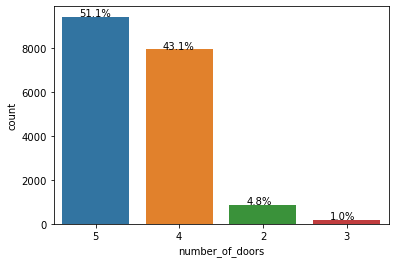

In [350]:
categorical_info("number_of_doors", train, rotate=0, x_shift_mult=1/4)

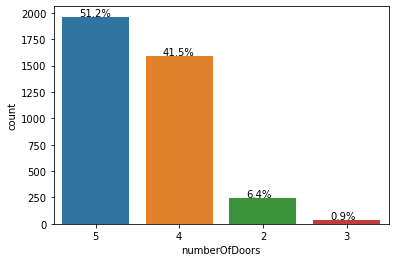

In [351]:
categorical_info("numberOfDoors", test, rotate=0, x_shift_mult=1/4)

Как видно, распределения выборок схожи, сделаем унификацию названий:

In [352]:
test.rename(columns={"numberOfDoors": "number_of_doors"}, inplace=True)

In [353]:
train.number_of_doors.dtype == test.number_of_doors.dtype

True

## productionDate (год производства автомобиля)

Приведем данные к типу int32 и посмотрим на распределения:

In [354]:
train.production_date = train.production_date.astype("int32")
test.productionDate = test.productionDate.astype("int32")

min    1973.000000
max    2020.000000
25%    2007.000000
50%    2011.000000
75%    2016.000000
std       7.430138
Name: production_date, dtype: float64


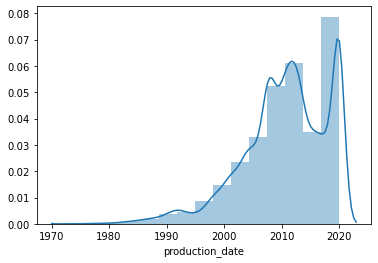

In [355]:
numeric_info(train.production_date, bins=15)

min    1981.000000
max    2019.000000
25%    2010.000000
50%    2013.000000
75%    2016.000000
std       5.186576
Name: productionDate, dtype: float64


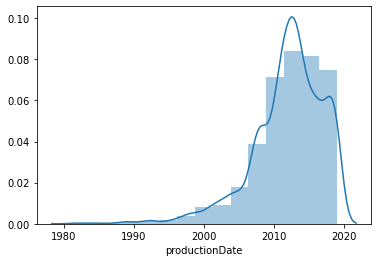

In [356]:
numeric_info(test.productionDate, bins=15)

Визуальный анализ показывает, что в тренировочном наборе есть пик для автомобилей 2020 года выпуска. Посмотрим на различия подробнее. В тестовом наборе данных года выпуска автомобилей находятся в диапазоне от 1981 до 2019. В тренировочном наборе есть автомобили выходящие за эти рамки (2020, 1976, 1977, 1978, 1979, 1980). 

Сделаем преобразование признака, получив новый, а именно: найдем возраст авто

In [357]:
train.production_date = 2020 - train.production_date
test.productionDate = 2020 - test.productionDate

In [358]:
test.rename(columns={"productionDate": "age"}, inplace=True)
train.rename(columns={"production_date": "age"}, inplace=True)

Посмотрим на распределения признака в обеих выборках после всех преобразований:

min     1.000000
max    39.000000
25%     4.000000
50%     7.000000
75%    10.000000
std     5.186576
Name: age, dtype: float64


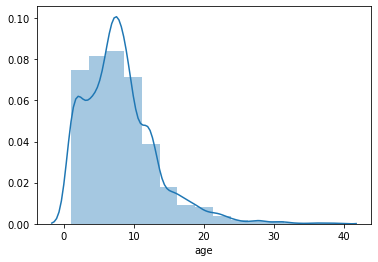

In [359]:
numeric_info(test.age, bins=15)

min     0.000000
max    47.000000
25%     4.000000
50%     9.000000
75%    13.000000
std     7.430138
Name: age, dtype: float64


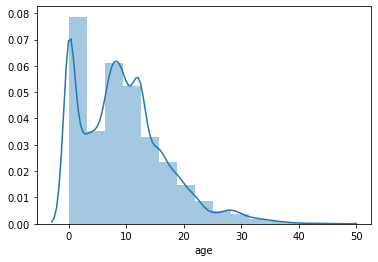

In [360]:
numeric_info(train.age, bins=15)

## vehicleTransmission (тип трансмиссии)

Сделаем переименование признака и посмотрим на распределение:

In [361]:
trans_dict = {'AUTOMATIC': "автоматическая",
              'MECHANICAL': "механическая",
              'ROBOT': "роботизированная"
              }
train.vehicle_transmission = train.vehicle_transmission.map(trans_dict)

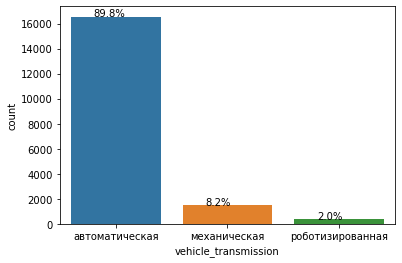

In [362]:
categorical_info("vehicle_transmission", train, rotate=0, x_shift_mult=1/4)

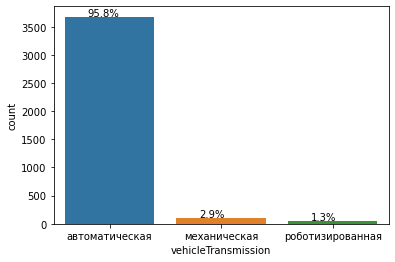

In [363]:
categorical_info("vehicleTransmission", test, rotate=0, x_shift_mult=1/4)

Как видно, в тренировочной выборке процент автомобилей с механической и роботизированной коробкой чуть выше. Сделаем унификацию:

In [364]:
trans_dict = {'автоматическая': "AT",
              'механическая': "MT",
              'роботизированная': "RT"
              }
train.vehicle_transmission = train.vehicle_transmission.map(trans_dict)
test.vehicleTransmission = test.vehicleTransmission.map(trans_dict)

In [365]:
test.rename(
    columns={"vehicleTransmission": "vehicle_transmission"}, inplace=True)

In [366]:
train.vehicle_transmission.dtype == test.vehicle_transmission.dtype

True

## engineDisplacement (объём двигателя)

Приведём данные к числовым и в train, и в test. Значения "undefined LTR" (электромобили) заменим на 0 (как в данных с сайта для тренировочной выборки)

In [367]:
test.engineDisplacement = test.engineDisplacement.apply(
    lambda x: float(x.split()[0]) if x.split()[0] != "undefined" else float(0))

In [368]:
train.engine_displacement = train.engine_displacement.map(
    lambda x: float(round(x/1000, 1)))

Рсапределения признака во многом похожи и имеют три пика для значений 2,3 и 4.5 литра. 

min    0.000000
max    6.600000
25%    2.000000
50%    2.500000
75%    3.000000
std    0.841743
Name: engine_displacement, dtype: float64


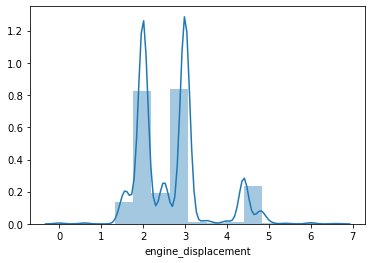

In [369]:
numeric_info(train.engine_displacement, bins=15)

min    0.000000
max    6.600000
25%    2.000000
50%    2.500000
75%    3.000000
std    0.819378
Name: engineDisplacement, dtype: float64


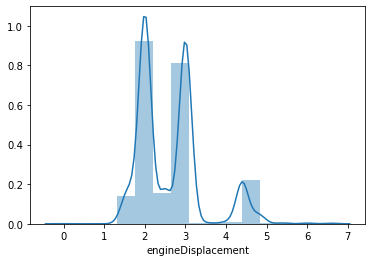

In [370]:
numeric_info(test.engineDisplacement, bins=15)

Анализ отличий показывает, что все виды объемов двигателей в тестовой выборке есть и в обучающей. Более того, в обучающей есть автомобили отличными объемами двигателя по сравнению с тестовой выборкой

In [371]:
difs = get_differences(train.engine_displacement, test.engineDisplacement)

Train - Test differences:

0.6    28
1.7     3
2.3     5
2.7     2
4.9     5
3.2    11
3.8     2
2.4    18
3.9     6
Name: engine_displacement, dtype: int64
Test - Train differences:

No differences


In [372]:
test.rename(
    columns={"engineDisplacement": "engine_displacement"}, inplace=True)

Посмотрим на количество автомобилей с электрическими двигателями:

In [373]:
len(train[train.engine_displacement == 0.0])

27

In [374]:
len(test[test.engine_displacement == 0.0])

1

Видим, что в тестовой выборке только один электрокар, а в тренировочной целых 27. Добавим новый признак "is_electro" принимающий значение 1, если двигатель электрический и 0, если нет:

In [375]:
train["is_electro"] = train.engine_displacement.apply(
    lambda x: 0 if x > 0 else 1)
test["is_electro"] = test.engine_displacement.apply(
    lambda x: 0 if x > 0 else 1)

In [376]:
train.engine_displacement.dtype == test.engine_displacement.dtype

True

## enginePower (мощность двигателя)

Приведем тестовые данные к числовому виду и посмотрим на распределения:

In [377]:
test.enginePower = test.enginePower.map(lambda x: int(x.split()[0]))

min     75.000000
max    625.000000
25%    184.000000
50%    218.000000
75%    272.000000
std     93.191001
Name: engine_power, dtype: float64


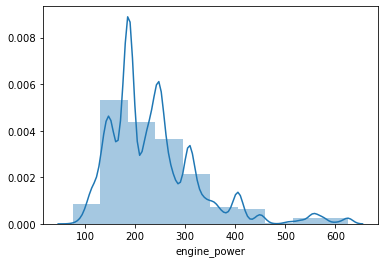

In [378]:
numeric_info(train.engine_power, bins=10)

min     90.000000
max    625.000000
25%    184.000000
50%    231.000000
75%    272.000000
std     91.429294
Name: enginePower, dtype: float64


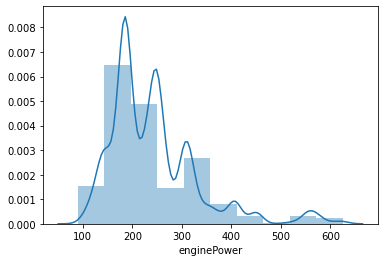

In [379]:
numeric_info(test.enginePower, bins=10)

Видно, что распределения схожи для обеих выборок, но посмотрим и на различия. Видим, что тестовый датасет содержит лишь небольшое количество автомобилей (3 шт.) с объемами двигателей, которых нет в тренировочной выборке. 

In [380]:
difs = get_differences(train.engine_power, test.enginePower)

Train - Test differences:

224     1
321     2
98      2
387    10
480     2
233     3
234     3
75      5
139     3
109     1
171     6
238    17
304     1
146     1
116    20
86      3
343     5
510     4
Name: engine_power, dtype: int64
Test - Train differences:

449    1
460    1
374    1
Name: enginePower, dtype: int64


In [381]:
test.rename(columns={"enginePower": "engine_power"}, inplace=True)

In [382]:
train.engine_power.dtype == test.engine_power.dtype

True

## mileage (пробег)

Приведем данные к типу int32 и посмотрим на распределения:

In [383]:
train.mileage = train.mileage.astype("int32")
test.mileage = test.mileage.astype("int32")

min          0.000000
max    1000000.000000
25%      50132.000000
50%     131750.000000
75%     208000.000000
std     113346.872297
Name: mileage, dtype: float64


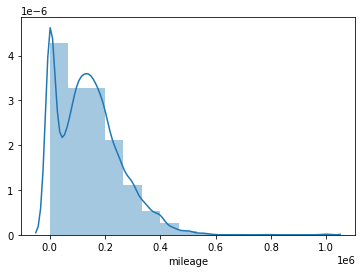

In [384]:
numeric_info(train.mileage, bins=15)

min          1.000000
max    1000000.000000
25%      58562.000000
50%     108000.000000
75%     160789.000000
std      85125.949826
Name: mileage, dtype: float64


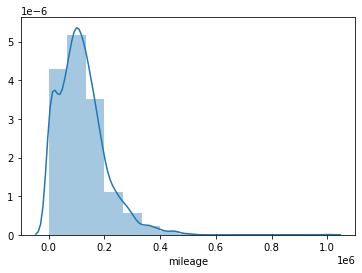

In [385]:
numeric_info(test.mileage, bins=15)

Видим, что распределния схожи за исключением лишь пика около 0 для новых автомобилей без пробега в тренировочной выборке

In [386]:
train.mileage.dtype == test.mileage.dtype

True

Добавим новый признак: разделим пробег на группы, исходя из того, что в среднем авто (данные Автостат) проходит за год 17000 км каждая группа будет грубо (не всегда пробег правдив) отображать количество лет эксплуатации. 

In [387]:
test["exp_year"] = test.mileage.apply(
    lambda x: x//17000 if x <= 400000 else 400000//17000+1)
train["exp_year"] = train.mileage.apply(
    lambda x: x//17000 if x <= 400000 else 400000//17000+1)

## Комплектация

Займемся теперь парсингом комплектации автомобилей

In [388]:
import re

In [389]:
options_unique_train = set()  # здесь соберем уникальные опции
options_list_train = []  # здесь все опции
row_options_train = []  # здесь опции для каждого отдельного авто
for idx, val in enumerate(train.complectation):
    row_options_train.append([])
    for opt in val.split(": True"):
        opt_var = re.sub(r'[\W_]+', '', opt)
        if opt_var != '':
            options_unique_train.add(opt_var)
            row_options_train[idx].append(opt_var)
            options_list_train.append(opt_var)

Далее создадим новый датафрейм, содержащий в себе цену и различные значения комплектации для оценки важности признаков:

In [390]:
#eq_data = pd.DataFrame(train.price)
# for option in options_unique_train:
#    eq_data[option]=0
#n = len(row_options_train)
# for row, option in enumerate(row_options_train):
#        print(round(100*row/(n-1),2),"%",end='\r')
#        eq_data.loc[row,option]=1
#eq_data.to_csv("features.csv", index = False, header = True)

Отберем только те значения признака, которые имеют корреляцию с ценой (по модулю) больше 0.3

In [391]:
#eq_data = pd.read_csv("features.csv")
#cor_target = abs(eq_data.corr()["price"])
#relevant_features = cor_target[cor_target>0.3]
#relevant_features.sort_values(ascending = False)[77:107]

In [392]:
train.shape

(18417, 24)

Добавим столбцы в тренировочный датасет с опциями, корреляция которых с ценой больше чем 0.3:

In [393]:
options_add = ['glonass', 'wirelesscharger', 'ledlights', 'applecarplay', 'autopark', 'laserlights', 'keylessentry', 'bodykit',
               'highbeamassist', 'paintmetallic', 'powerlatchingdoors', 'bas', 'electrotrunk', 'activsuspension',
               'frontseatsheatvent', 'projectiondisplay', 'decorativeinteriorlighting', 'electronicgagepanel',
               'multizoneclimatecontrol', 'automirrors', 'adaptivelight', 'tyrepressure', 'isofix', 'wheelheat',
               '360camera', 'usb', 'bluetooth', 'asr', 'lightsensor', 'airbagcurtain', 'navigation', 'startbutton',
               'voicerecognition', 'rainsensor',  'collisionpreventionassist', '12vsocket', 'drl', 'airsuspension',
               'lanekeepingassist',  'multiwheel', 'blindspot', 'roofrails', 'passengerseatelectric', 'wheelleather',
               '22inchwheels', 'steeringwheelgearshiftpaddles', 'thirdrearheadrest', 'sportseats', 'frontcentrearmrest',
               'trafficsignrecognition', 'remoteenginestart', 'mirrorsheat']

new_features = options_add

for idx, option_add in enumerate(options_add):
    pars = []
    for val in row_options_train:
        if option_add in val:
            pars.append(1)
        else:
            pars.append(0)
    train[new_features[idx]] = pd.Series(pars)

In [414]:
train.shape

(18417, 76)

Аналогичные преобразования проделаем с тестовым датасетом:

In [395]:
options_unique_test = set()
options_list_test = []
row_options_test = []
for idx, val in enumerate(test["Комплектация"]):
    row_options_test.append([])
    for opt in val.split("},{"):
        if opt == '[]':
            continue
        for var in opt.split('"values":')[1].split(","):
            opt_var = re.sub(r'[\W_]+', '', var)
            if opt_var != '':
                options_unique_test.add(opt_var)
                row_options_test[idx].append(opt_var)
                options_list_test.append(opt_var)

In [415]:
test.shape

(3837, 77)

In [397]:
options_add = ['ЭРАГЛОНАСС', 'Беспроводнаязарядкадлясмартфона', 'Светодиодныефары', 'CarPlay', 'Системаавтоматическойпарковки', 'Лазерныефары',
               'Системадоступабезключа', 'Обвескузова', 'Системауправлениядальнимсветом', 'Металлик', 'Доводчикдверей',
               'СистемапомощиприторможенииBAS', 'Электроприводкрышкибагажника', 'Активнаяподвеска', 'Вентиляцияпереднихсидений',
               'Проекционныйдисплей', 'Декоративнаяподсветкасалона', 'Электроннаяприборнаяпанель', 'Климатконтрольмногозонный',
               'Электроскладываниезеркал', 'Системаадаптивногоосвещения', 'Датчикдавлениявшинах', 'КреплениедетскогокреслапереднийрядISOFIX',
               'Обогреврулевогоколеса', 'Камера360', 'USB', 'Bluetooth', 'АнтипробуксовочнаясистемаASR', 'Датчиксвета',
               'Подушкибезопасностиоконныешторки', 'Навигационнаясистема', 'Запускдвигателяскнопки', 'Голосовоеуправление',
               'Датчикдождя', 'Системапредотвращениястолкновения', 'Розетка12V', 'Дневныеходовыеогни', 'Пневмоподвеска',
               'Системаконтролязаполосойдвижения', 'Мультифункциональноерулевоеколесо', 'Системаконтроляслепыхзон',
               'Рейлингинакрыше', 'Электрорегулировкапереднихсидений', 'Отделкакожейрулевогоколеса', 'Диски22',
               'Подрулевыелепесткипереключенияпередач', 'Третийзаднийподголовник', 'Спортивныепередниесиденья',
               'Переднийцентральныйподлокотник', 'Системараспознаваниядорожныхзнаков', 'Дистанционныйзапускдвигателя',
               'Электрообогревбоковыхзеркал']

for idx, option_add in enumerate(options_add):
    pars = []
    for val in row_options_test:
        if option_add in val:
            pars.append(1)
        else:
            pars.append(0)
    test[new_features[idx]] = pd.Series(pars)

In [416]:
test.shape

(3837, 77)

## Привод

Унифицируем названия признаков в выборках и посмотрим на распределения:

In [399]:
gear_dict = {'ALL_WHEEL_DRIVE': "полный",
             'REAR_DRIVE': "задний",
             'FORWARD_CONTROL': "передний"
             }
train.gear_type = train.gear_type.map(gear_dict)

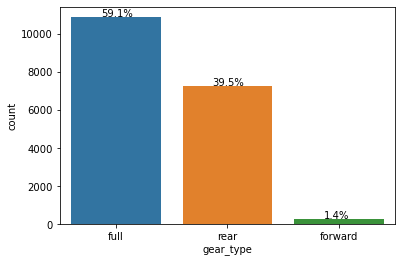

In [417]:
categorical_info("gear_type", train, rotate=0, x_shift_mult=1/3)

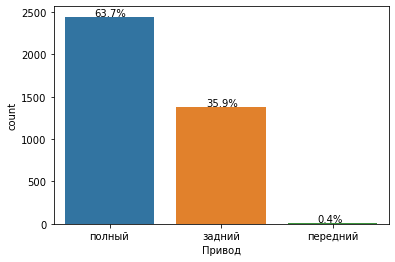

In [401]:
categorical_info("Привод", test, rotate=0, x_shift_mult=1/3)

Распределения признака в обеих выборках близки

In [402]:
test.rename(columns={"Привод": "gear_type"}, inplace=True)

In [403]:
gear_dict = {'полный': "full",
             'задний': "rear",
             'передний': "forward"
             }
train.gear_type = train.gear_type.map(gear_dict)
test.gear_type = test.gear_type.map(gear_dict)

In [404]:
train.gear_type.dtype == test.gear_type.dtype

True

## Руль 

In [405]:
if len(test["Руль"].unique()) == 1:
    print(
        f'Тестовый датасет полностью представлен автомобилями с типом руля {test["Руль"].unique()[0]}')

Тестовый датасет полностью представлен автомобилями с типом руля Левый


А в тренировочном есть небольшое количество праворульных авто, поэтому оставим этот признак. 

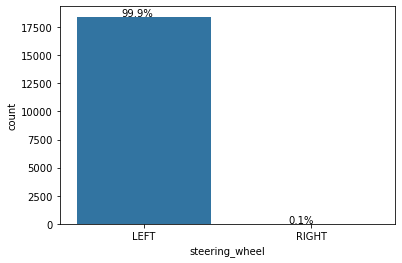

In [406]:
categorical_info("steering_wheel", train, rotate=0, x_shift_mult=1/3)

In [407]:
test.rename(columns={"Руль": "steering_wheel"}, inplace=True)

In [408]:
wheel_dict = {'Левый': "LEFT"
              }
test.steering_wheel = test.steering_wheel.map(wheel_dict)

In [409]:
train.steering_wheel.dtype == test.steering_wheel.dtype

True

## Состояние

In [410]:
print(
    f'Тестовый датасет полностью представлен автомобилями с состоянием: {test["Состояние"].unique()[0]}')

Тестовый датасет полностью представлен автомобилями с состоянием: Не требует ремонта


In [411]:
print(
    f'Тренировочный датасет полностью представлен автомобилями с состоянием not_damage: {train["not_damage"].unique()[0]}')

Тренировочный датасет полностью представлен автомобилями с состоянием not_damage: True


Как видно, все автомобили тренировочной выборки тоже не требуют ремонта, исключим признак из рассмотрения

In [412]:
test.rename(columns={"Состояние": "not_damage"}, inplace=True)

In [413]:
train.not_damage.dtype == test.not_damage.dtype

False

## Владельцы

У признака из обучающей выборки имеются пропуски:

In [418]:
print(100*round(sum(train.owners.isna())/len(train), 2), "%", sep="")

15.0%


In [419]:
owners_dict = {1.0: "one",
               2.0: "two",
               3.0: "three_more",
               np.nan: np.nan
               }
train.owners = train.owners.map(owners_dict)

Количество владельцев во многом зависит от возраста авто. Посмотрим на медианы возраста авто с пропущенными значениями количества владельцев:

In [420]:
for owners in list(train.owners.value_counts().index):
    print(owners, train[train.owners == owners].age.median())

three_more 12.0
two 8.0
one 4.0


Также посмотрим на конкретные значения возраста для пропусков:

In [421]:
train[train.owners.isna()].age.value_counts()

0     2711
1       57
2        6
17       2
6        1
Name: age, dtype: int64

Заменим пропуски по правилу: если старше 12 лет, то три и более владельцев, если моложе 10 и старше 6, то 2, иначе - 1

In [422]:
def is_missing(owner, year):

    if pd.isnull(owner):
        if year <= 6:
            return "one"
        elif year <= 10:
            return "two"
        else:
            return "three_more"
    else:
        return owner


train.owners = train.apply(lambda x: is_missing(x['owners'], x['age']), axis=1)

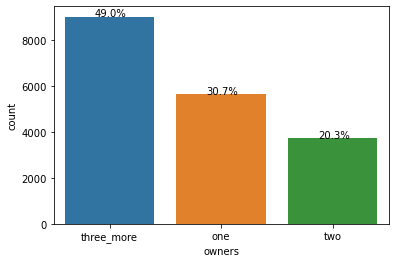

In [702]:
categorical_info("owners", train, rotate=0, x_shift_mult=1/3)

In [426]:
test.rename(columns={"Владельцы": "owners"}, inplace=True)

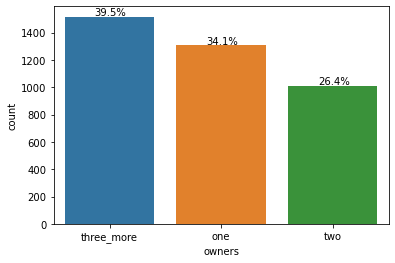

In [430]:
categorical_info("owners", test, rotate=0, x_shift_mult=1/3)

Сделаем унификацию названий признака:

In [428]:
owners_dict = {'1\xa0владелец': "one",
               '2\xa0владельца': "two",
               '3 или более': "three_more"
               }
test.owners = test.owners.map(owners_dict)

In [429]:
train.owners.dtype == test.owners.dtype

True

## ПТС

У признака из обучающей выборки имеются пропуски:

In [431]:
train.shape

(18417, 76)

In [432]:
sum(train.pts_origin.isna())

197

In [433]:
print(100*round(sum(train.pts_origin.isna())/len(train), 6), "%", sep="")

1.0697%


Заполним nan новой категорией 'unknown'

In [434]:
#train.dropna(subset = ["pts_origin"],inplace=True)
train.pts_origin.fillna("unknown", inplace=True)

In [435]:
pts_dict = {'ORIGINAL': "original",
            'DUPLICATE': "duplicate",
            "unknown": "unknown"
            }
train.pts_origin = train.pts_origin.map(pts_dict)

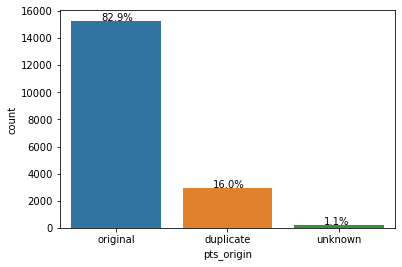

In [436]:
categorical_info("pts_origin", train, rotate=0, x_shift_mult=1/3)

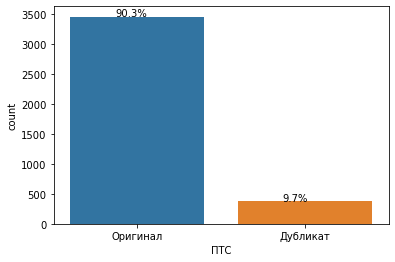

In [437]:
categorical_info("ПТС", test, rotate=0, x_shift_mult=1/3)

In [438]:
test.rename(columns={"ПТС": "pts_origin"}, inplace=True)

In [439]:
pts_dict = {'Оригинал': "original",
            'Дубликат': "duplicate"
            }
test.pts_origin = test.pts_origin.map(pts_dict)

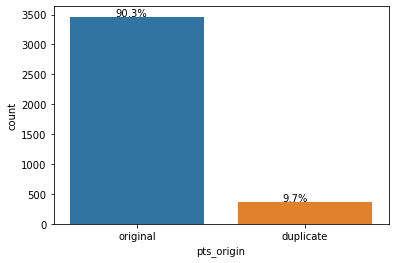

In [440]:
categorical_info("pts_origin", test, rotate=0, x_shift_mult=1/3)

In [441]:
train.pts_origin.dtype == test.pts_origin.dtype

True

## Таможня

In [442]:
print(
    f'Обучающий датасет полностью представлен автомобилями с состоянием таможня пройдена: {train["custom_clear"].unique()[0]}')

Обучающий датасет полностью представлен автомобилями с состоянием таможня пройдена: True


In [443]:
print(
    f'Тестовый датасет полностью представлен автомобилями с состоянием: {test["Таможня"].unique()[0]}')

Тестовый датасет полностью представлен автомобилями с состоянием: Растаможен


Удалим этот признак из-за отсутствия информативности для модели

## Цена

In [720]:
#train1 = pd.read_csv("raw_data.csv")

In [721]:
#train.price = train1.price.astype("int32")

min    3.000000e+04
max    1.629000e+07
25%    6.100000e+05
50%    1.100000e+06
75%    2.492974e+06
std    1.985539e+06
Name: price, dtype: float64


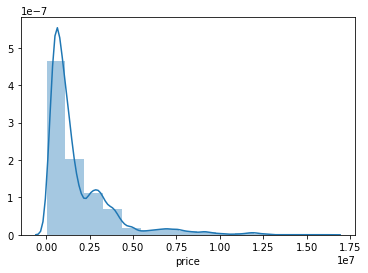

In [444]:
numeric_info(train.price, bins=15)

Цена имеет унимодальное распределение с длинным правом концом. Введем поправочный коэффициент цены, равный примерному отношению курса доллара для периода сбора данных тестового и тренировочного датасетов:

In [445]:
# коэффициент был подобран опытным путем
train['price'] = train['price'] * 0.90

min    2.700000e+04
max    1.466100e+07
25%    5.490000e+05
50%    9.900000e+05
75%    2.243677e+06
std    1.786985e+06
Name: price, dtype: float64


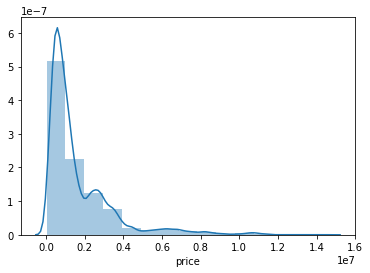

In [446]:
numeric_info(train.price, bins=15)

Прологарифмируем признак price, чтобы сделать его похожим на нормальное распределение:

In [447]:
train['price'] = np.log(train["price"])

min    10.203592
max    16.500701
25%    13.215854
50%    13.805460
75%    14.623626
std     0.961676
Name: price, dtype: float64


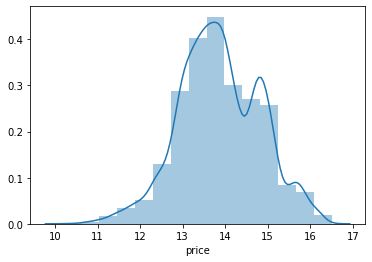

In [448]:
numeric_info(train.price, bins=15)

## Covid

Добавим признак covid в данные: тестовый датасет был собран в начале эпидемии (март - февраль), когда она набирала обороты, а тренировочный в августе, когда эпидемия пошла на спад.

In [449]:
test["Covid"] = 0
train["Covid"] = 1

## Tax

Попробуем также добавить признак tax, означающий налог, взымаемый с владельца авто. Налог рассчитывается по формуле: 

Размер налога = Ставка налога * Налоговая база * (Количество месяцев владения/12) * Повышающий коэффициент.

Ставка налога варьируется от региона к региону. Возьмем ставку по городу Москва. Она варьируется от 12 до 150 руб/л.с. в зависимости от мощности двигателя. Налоговая база это мощность двигателя в л.с. Количество месяцев владения нам неизвестно, поэтому предположим, что ведем расчет для 12 месяцев. Повышающий коэффициент зависит от стоимости и возраста авто. К сожалению, его использовать не получится в виду отсутствия цены в тесте. Поэтому условно предположим, что он равен 1 для всех авто. Данные по ставкам и повышающему коэффициенту можно взять здесь: [коэффициент](https://nalog-nalog.ru/transportnyj_nalog/raschet_transportnogo_naloga/povyshayuwij_koefficient_dlya_transportnogo_naloga/) и [ставки](https://glavkniga.ru/situations/s509668)

In [450]:
def rate(power):
    if power > 250:
        return 150
    elif power > 225:
        return 75
    elif power > 200:
        return 65
    elif power > 175:
        return 50
    elif power > 150:
        return 45
    elif power > 125:
        return 35
    elif power > 100:
        return 25
    else:
        return 12

In [451]:
def calc_tax(row):
    return rate(row["engine_power"])*row["engine_power"]

In [452]:
train["tax"] = train.apply(lambda row: calc_tax(row), axis=1)
test["tax"] = test.apply(lambda row: calc_tax(row), axis=1)

min      900.000000
max    93750.000000
25%     9200.000000
50%    14170.000000
75%    40800.000000
std    20799.087658
Name: tax, dtype: float64


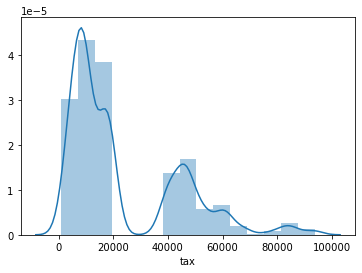

In [453]:
numeric_info(train.tax, bins=15)

## Сохранение данных

In [463]:
train.columns

Index(['body_type', 'color', 'fuel_type', 'model_date_begin', 'name',
       'number_of_doors', 'age', 'vehicle_transmission', 'engine_displacement',
       'engine_power', 'mileage', 'gear_type', 'steering_wheel', 'owners',
       'pts_origin', 'price', 'is_electro', 'exp_year', 'glonass',
       'wirelesscharger', 'ledlights', 'applecarplay', 'autopark',
       'laserlights', 'keylessentry', 'bodykit', 'highbeamassist',
       'paintmetallic', 'powerlatchingdoors', 'bas', 'electrotrunk',
       'activsuspension', 'frontseatsheatvent', 'projectiondisplay',
       'decorativeinteriorlighting', 'electronicgagepanel',
       'multizoneclimatecontrol', 'automirrors', 'adaptivelight',
       'tyrepressure', 'isofix', 'wheelheat', '360camera', 'usb', 'bluetooth',
       'asr', 'lightsensor', 'airbagcurtain', 'navigation', 'startbutton',
       'voicerecognition', 'rainsensor', 'collisionpreventionassist',
       '12vsocket', 'drl', 'airsuspension', 'lanekeepingassist', 'multiwheel',
       

Уберём из данных все признаки, которые нужно убрать, исходя из проведенного анализа:

In [455]:
train.drop(['brand', 'model_date_end', 'model_name', 'complectation',
            'not_damage', 'custom_clear'], axis=1, inplace=True)

In [456]:
test.columns

Index(['body_type', 'brand', 'color', 'fuel_type', 'model_date_begin', 'name',
       'number_of_doors', 'age', 'vehicleConfiguration',
       'vehicle_transmission', 'engine_displacement', 'engine_power',
       'description', 'mileage', 'Комплектация', 'gear_type', 'steering_wheel',
       'not_damage', 'owners', 'pts_origin', 'Таможня', 'Владение', 'id',
       'is_electro', 'exp_year', 'glonass', 'wirelesscharger', 'ledlights',
       'applecarplay', 'autopark', 'laserlights', 'keylessentry', 'bodykit',
       'highbeamassist', 'paintmetallic', 'powerlatchingdoors', 'bas',
       'electrotrunk', 'activsuspension', 'frontseatsheatvent',
       'projectiondisplay', 'decorativeinteriorlighting',
       'electronicgagepanel', 'multizoneclimatecontrol', 'automirrors',
       'adaptivelight', 'tyrepressure', 'isofix', 'wheelheat', '360camera',
       'usb', 'bluetooth', 'asr', 'lightsensor', 'airbagcurtain', 'navigation',
       'startbutton', 'voicerecognition', 'rainsensor',
       'co

Уберём из данных все признаки, которые нужно убрать, исходя из проведенного анализа:

In [457]:
test.drop(['brand', 'vehicleConfiguration', 'description', 'Комплектация',
           'not_damage', 'Таможня', 'Владение', 'id'], axis=1, inplace=True)

In [458]:
test.shape, train.shape

((3837, 71), (18417, 72))

Проверим идентичность имён столбцов:

In [462]:
sum(test.columns == train.drop("price", axis=1).columns)

71

Сохраним предобработанные данные:

In [738]:
train.to_csv("train_stack_tax.csv", index=False, header=True)

In [739]:
test.to_csv("test_stack_tax.csv", index=False, header=True)